Reference: https://github.com/twitterdev/do_more_with_twitter_data/blob/master/examples/timeseries/timeseries.ipynb

In [1]:
import datetime
import functools
import itertools
from pathlib import Path
import timeit
import warnings; warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer

from sm_analysis.utils import *
from sm_analysis.graph import *
from sm_analysis.time_series import *
from sm_analysis.topic_modeling import *
from sm_analysis.twitter import *

In [2]:
%matplotlib notebook
plt.style.use("bmh")

pd.options.display.float_format = '{:.2f}'.format

In [3]:
counts = ['like_count',
         'quote_count',
         'reply_count',
         'retweet_count',
         ]
plot_stats = ['mean',
             'std',
             ]
stats = ['mean',
         'std',
         'min',
         'max',
        ]

# Timeseries

In [4]:
users = UsersData('data/users')
tweets = TweetsData('data/tweets')

In [5]:
df = tweets.df.loc[:][:]
user_df = users.df.loc[:][:]
campaign = df[df['campaign'] == 'iran202012']
campaign_users = user_df[user_df['campaign'] == 'iran202012']

In [6]:
campaign_start = min(campaign['tweet_time'])
campaign_end = max(campaign['tweet_time'])
campaign_period = campaign_end - campaign_start

print(campaign_start)
print(campaign_end)
print(campaign_period)

2009-09-06 13:56:00
2020-12-27 18:08:00
4130 days 04:12:00


In [7]:
campaign_years = campaign_period / np.timedelta64(1, "Y")
campaign_years

11.30803507258876

In [8]:
def resample_ts(df, freq):
    return (df
             .set_index('tweet_time')
             .resample(freq)
             .size()
             .reset_index()
             .rename(columns={0:'per_{}_count'.format(freq)})
             .set_index('tweet_time')
            )

<IPython.core.display.Javascript object>


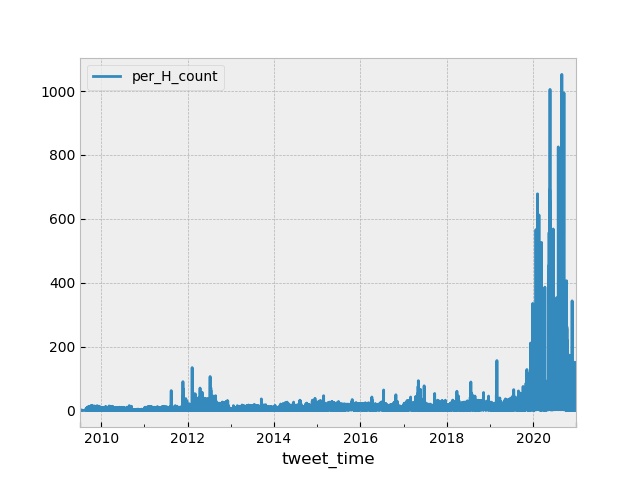

In [9]:
hourly = resample_ts(df, 'H')
hourly.plot()

<IPython.core.display.Javascript object>


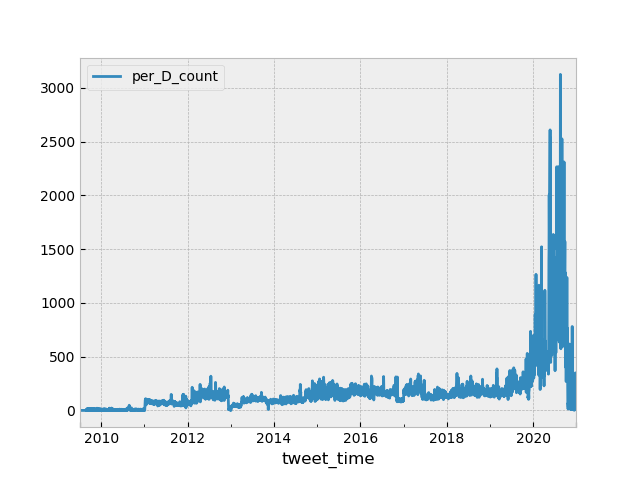

In [10]:
daily = resample_ts(df, 'D')
daily.plot()

In [11]:
print('hourly tweets:\n{}'.format(hourly
                                 .describe().loc[stats]
                                 .astype('int')
                                )
     )

hourly tweets:
      per_H_count
mean            7
std            17
min             0
max          1052


<IPython.core.display.Javascript object>


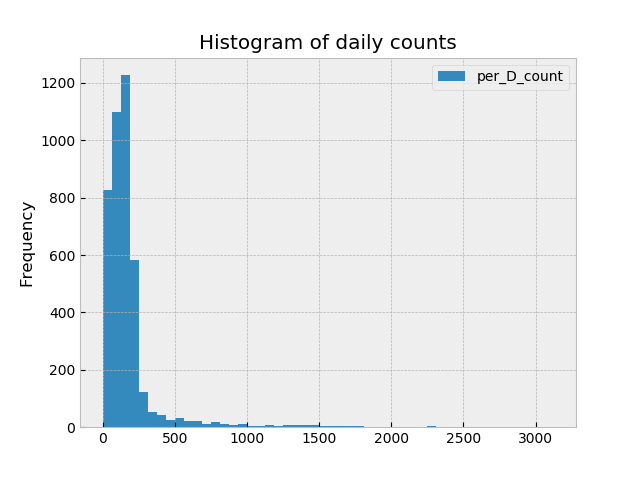

In [12]:
(daily
 .plot.hist(bins=50, title="Histogram of daily counts")
)

In [13]:
top_days = (daily
 .sort_values(by='per_D_count', ascending=False)
 .query('per_D_count > 250')
 .sort_index()
)
len(top_days)

456

<IPython.core.display.Javascript object>


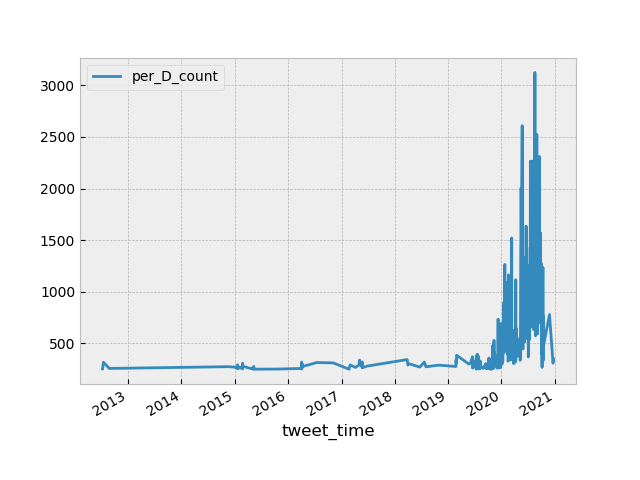

In [14]:
top_days.plot()

## Differencing

We can use simple differencing to get a sense of the change in tweet volume from day to day during the measured time period. This provides a measure of the variability in activity during parts of the campaign.

In [15]:
daily_diff = (daily
             .diff()
             )
daily_std_diff = (daily
             .pipe(standardize)
             .diff()
            )

In [16]:
print(daily_diff
      .describe()
      .loc[['mean','std','min','max']]
)
print('\nstandardized:\n',
        daily_std_diff
         .describe()
         .loc[['min','max']]
)

      per_D_count
mean         0.01
std        117.46
min      -1980.00
max       1836.00

standardized:
      per_D_count
min        -8.33
max         7.72


<IPython.core.display.Javascript object>


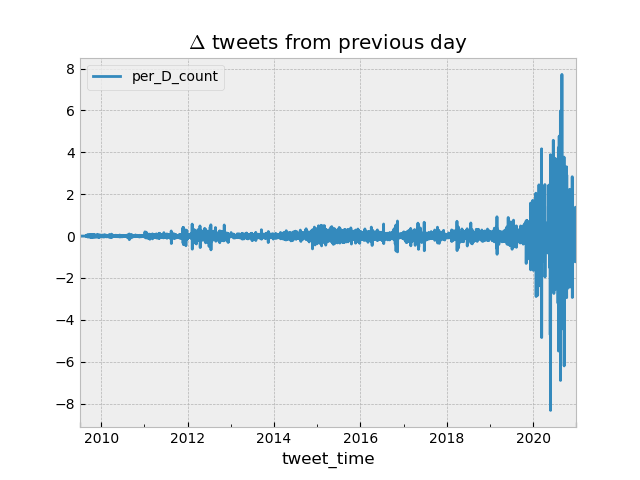

In [17]:
daily_std_diff.plot(title="$\Delta$ tweets from previous day")

In [18]:
hourly_diff = (hourly
              .diff()
              )

hourly_std_diff = (hourly
                     .pipe(standardize)
                     .diff()
                    )

<IPython.core.display.Javascript object>


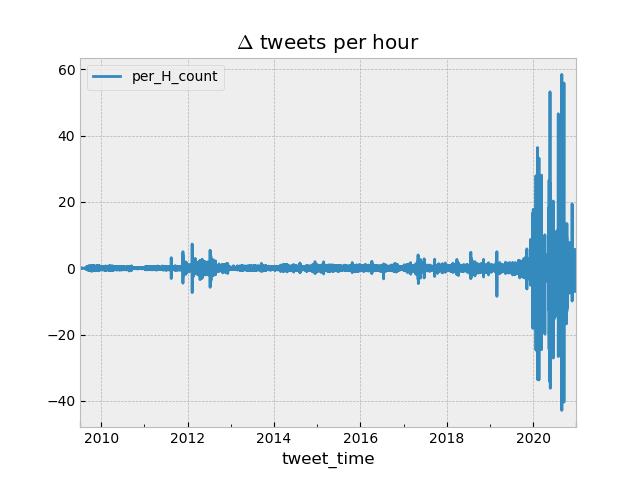

In [19]:
hourly_std_diff.plot(title="$\Delta$ tweets per hour")

<IPython.core.display.Javascript object>


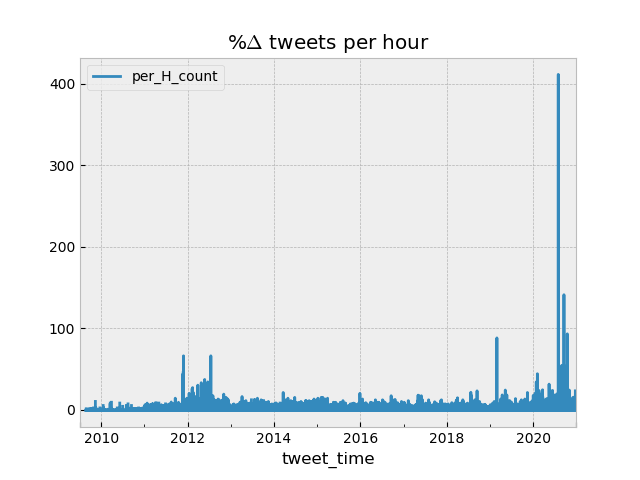

In [20]:
(hourly
 .pct_change()
).plot(title="%$\Delta$ tweets per hour")

## Rolling statistics

Rolling statistics can be used to smooth out the signal and show trends more clearly.

<IPython.core.display.Javascript object>


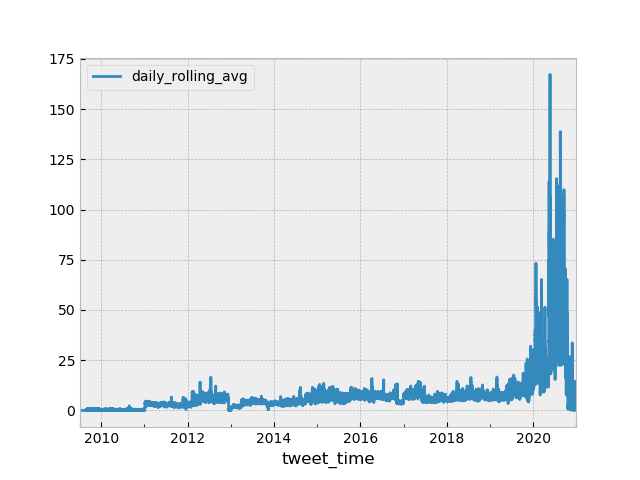

In [21]:
(hourly
 .rolling(24)
 .mean()
 .rename(columns={'per_H_count':'daily_rolling_avg',
                  'tweet_time':'time'})
 .fillna(0)
).plot()

<IPython.core.display.Javascript object>


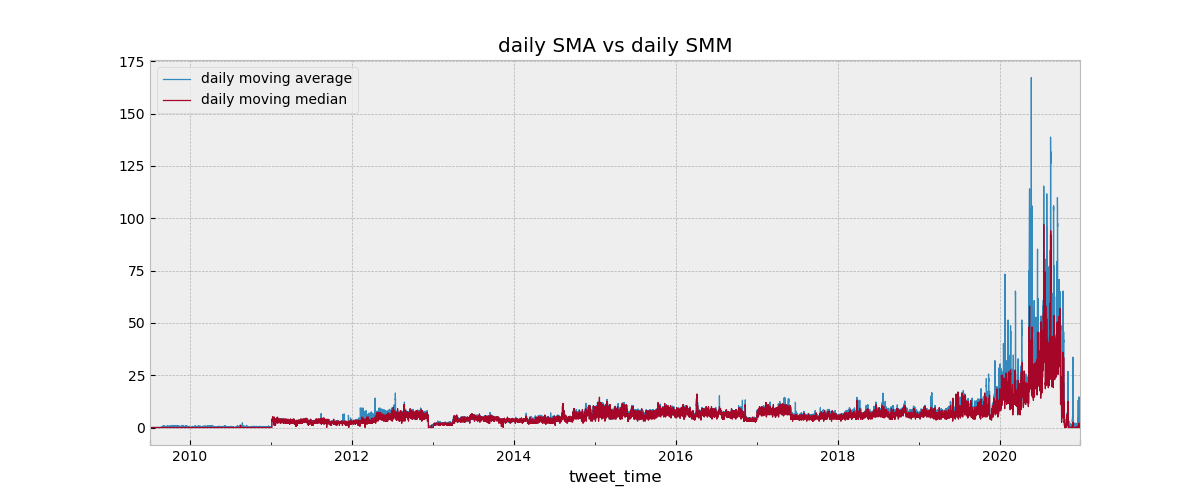

In [22]:
fig, axes = plt.subplots(1,1,figsize=(12, 5))

(hourly
 .rolling(24)
 .mean()
 .rename(columns={'per_H_count': 'daily moving average'})
 .plot(ax=axes, lw=0.9))

(hourly
 .rolling(24)
 .median()
 .rename(columns={'per_H_count': 'daily moving median'})
 .plot(ax=axes, lw=0.9))

axes.set_title(label="daily SMA vs daily SMM");

The median is more robust than the mean to outlier values, which also helps us see a smoother signal and more general trend.

<IPython.core.display.Javascript object>


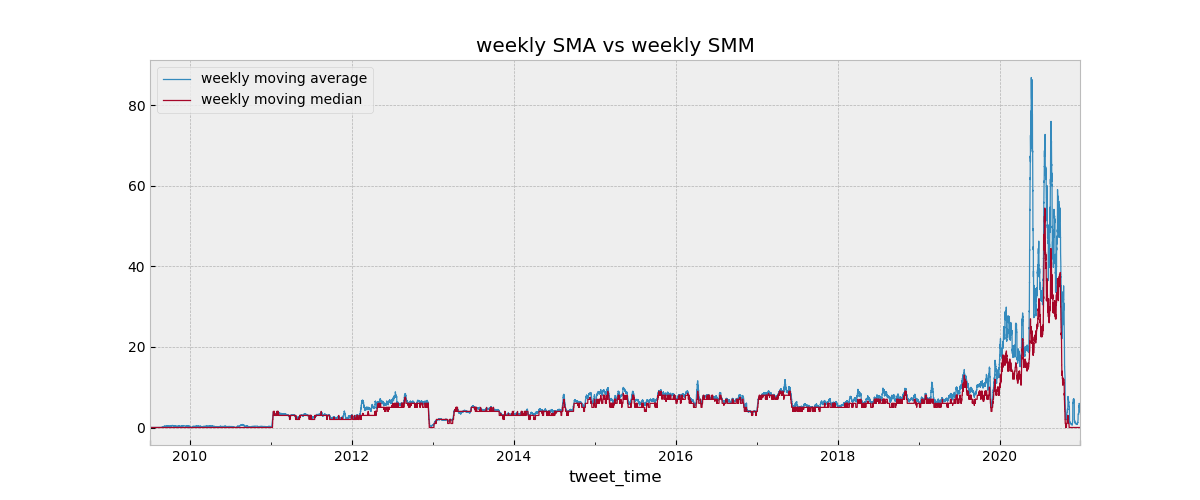

In [23]:
fig, axes = plt.subplots(1,1,figsize=(12, 5))

(hourly
 .rolling(24*7)
 .mean()
 .rename(columns={'per_H_count': 'weekly moving average'})
 .plot(ax=axes, lw=0.9));

(hourly
 .rolling(24*7)
 .median()
 .rename(columns={'per_H_count': 'weekly moving median'})
 .plot(ax=axes, lw=0.9));

axes.set_title(label="weekly SMA vs weekly SMM");

Here we observe the difference between time periods used for computing the rolling statistic.

<IPython.core.display.Javascript object>


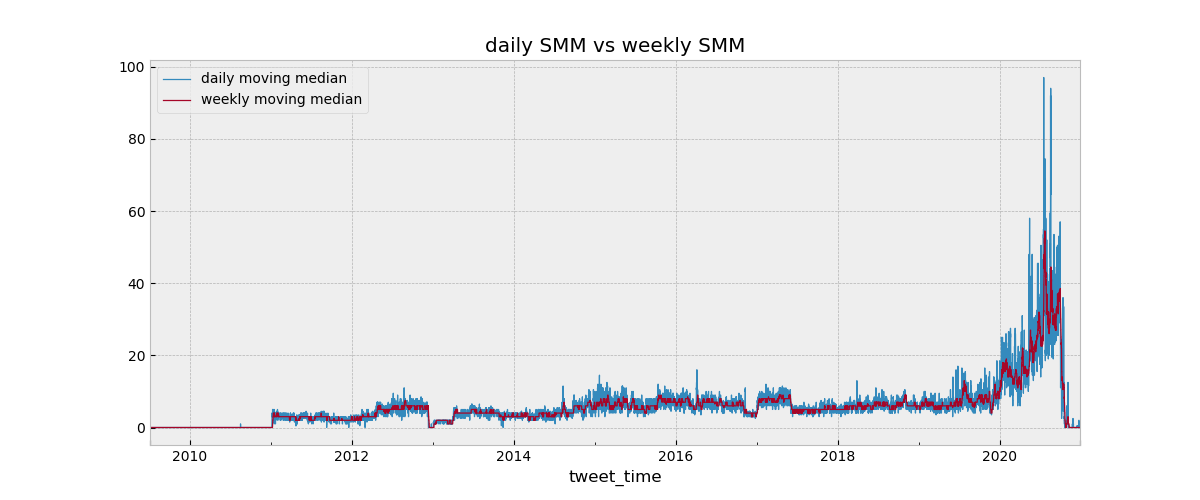

Text(0.5, 1.0, 'daily SMM vs weekly SMM')

In [24]:
fig, axes = plt.subplots(1,1,figsize=(12, 5))

(hourly
 .rolling(24)
 .median()
 .rename(columns={'per_H_count': 'daily moving median'})
 .plot(ax=axes, lw=0.9))

(hourly
 .rolling(24*7)
 .median()
 .rename(columns={'per_H_count': 'weekly moving median'})
 .plot(ax=axes, lw=0.9))

axes.set_title(label="daily SMM vs weekly SMM")

## Time period
These initial views show a clear increase in tweet volume after 2019. Further analysis could for instance compare properties of tweets before 2019 with tweets after 2019. It appears that the campaign was more active in the latter period, so separating the two could show the difference between the active component of the campaign, and the earlier low-volumes activity.

We can also look at high-volume days of the campaign:

In [25]:
grouped = (campaign
 .reset_index()
 .set_index('tweet_time')
 .resample('D')[['tweetid','userid','tweet_text']]
)

(grouped
 .size()
 .sort_values(ascending=False)
).head()

tweet_time
2020-08-17    3061
2020-05-22    2559
2020-08-30    2493
2020-05-25    2480
2020-09-17    2229
dtype: int64

In [26]:
top_day = (grouped
 .size()
 .sort_values(ascending=False)
).idxmax()

top_day_tweets = grouped.get_group(top_day)

In [27]:
top_day_tweets

,tweetid,userid,tweet_text
tweet_time,,,
2020-08-17 00:02:00,1295149036681474048,213589457,RT @irXcL8Y80STibhjlS3a48BahFUg3yqPT+XtTxkpLL8...
2020-08-17 00:02:00,1295149057372033024,jWkurFac8vhkrkKlTqvhjp4rwEVXCuZ7uOhVc+bs1ZY=,@safewordthe2nd @Mahyargdrz عه نه! چرا!؟ پس کی...
2020-08-17 00:15:00,1295152130546900995,213589457,Una fuente saudí afirma que el príncipe herede...
2020-08-17 00:30:00,1295155883819667458,etDaWEjMPleueDrpkatPUSCApc6yU8W95+yZYWzVxSY=,Dirgahayu RI ke 75 Jangan sia-siain jasa pah...
2020-08-17 00:30:00,1295155884205789185,etDaWEjMPleueDrpkatPUSCApc6yU8W95+yZYWzVxSY=,"""Kita berutang kepada Palestina. Palestina yan..."
...,...,...,...
2020-08-17 23:07:00,1295497456873082881,C9vGau5jQ1ePnWmaL5h01KM639A6QbtYskwsE1Tlk=,While COVID-19 continues to spread unchecked t...
2020-08-17 23:08:00,1295497640570953730,C9vGau5jQ1ePnWmaL5h01KM639A6QbtYskwsE1Tlk=,@washingtonpost A lack of testing in Yemen mea...
2020-08-17 23:09:00,1295498020373565442,C9vGau5jQ1ePnWmaL5h01KM639A6QbtYskwsE1Tlk=,@MSNBC COVID-19 has worsened an already collap...


### Topic modeling for top day

In [28]:
def extract_topics(documents,
                   vectorizer=None,
                   n_samples=2000,
                   n_features=1000,
                   n_components=10,
                   n_top_words=20,
                   apply_preprocessing=True,
                   stop_words=None,
                   ):
    
    tokenize_partial = functools.partial(tokenize_string, stop_words=stop_words)
    preprocess_partial = functools.partial(preprocess_string, special_tokens=False)
    
    if stop_words == None:
        stop_words = [*stopwords.words(),
                      '[url]', '[at]', '[htag]',]
    if vectorizer == None:
        tokenize_partial = functools.partial(tokenize_string, 
                                             stop_words=stop_words)
        preprocess_partial = functools.partial(preprocess_string, 
                                               special_tokens=False)
        vectorizer = CountVectorizer(analyzer='word',
                             strip_accents='ascii',
                             stop_words=stop_words,
                             ngram_range=(1,2),
                             preprocessor=preprocess_partial,
                             tokenizer=tokenize_partial,
                            )
    if apply_preprocessing:
        documents = (documents
                          .map(long_string)
                          .map(preprocess_string)
                         )

    print('vectorizing...')
    tf = vectorizer.fit_transform(documents)
        
    
    print(('LDA:\nn_samples: {}\nn_features: {}\nn_components: {}')
          .format(n_samples, n_features, n_components))

    lda = LatentDirichletAllocation(n_components=n_components, 
                                    max_iter=5,
                                    learning_method='online',
                                    learning_offset=50.,
                                    random_state=0)

    lda.fit(tf)
    
    tf_feature_names = vectorizer.get_feature_names()

    plot_top_words(lda, 
                   tf_feature_names, 
                   n_top_words,
                   n_components,
                   'Categories in LDA model')
    plt.tight_layout()

In [29]:
string_agg = lambda x: list(x)

In [30]:
top_days = (campaign
 .reset_index()
 .set_index('tweet_time')
 .resample('D')[['tweetid','tweet_text']]
 .agg({'tweetid':'size','tweet_text':string_agg})
 .sort_values(by='tweetid', ascending=False)
)

In [31]:
top_days.head(5)

,tweetid,tweet_text
tweet_time,,
2020-08-17,3061,[RT @irXcL8Y80STibhjlS3a48BahFUg3yqPT+XtTxkpLL...
2020-05-22,2559,[Todos los musulmanes y personas libres del mu...
2020-08-30,2493,[#Rusia alerta que los servicios de inteligenc...
2020-05-25,2480,[Un internauta venezolano sugiere que su carro...
2020-09-17,2229,[#China celebra el fallo de la Organización Mu...


In [32]:
user_tweets = (top_days['tweet_text']).iloc[0]
user_tweets[55:75]

['Normalisasi katanya menyelamatkan dunia arab? Prett #UAEBetraysPalestine',
 'Bukan hanya Palestina, tapi UAE korbankan harga diri semua negara #UAEBetraysPalestine',
 'Sekarang UAE, kita tunggu giliran Saudi Arabia khianati Palestina #UAEBetraysPalestine',
 'Sekarang UAE, kita tunggu giliran negara rab lainnya khianati Palestina #UAEBetraysPalestine',
 'Sekarang UAE, kita tunggu giliran Bahrain khianati Palestina #UAEBetraysPalestine',
 'Normalisasi UAE-Israel berarti kehancuran Palestina #UAEBetraysPalestine',
 'Normalisasi UAE-Israel berarti kehancuran negara teluk #UAEBetraysPalestine',
 'Normalisasi katanya menyelamatkan sosial timur tengah? Cape dehh #UAEBetraysPalestine',
 'Muslim tidak akan menusuk muslim lainnya dari belakang.\n#UAEBetraysPalestine',
 'Binasalah Normalisasi UAE-Rezim Pendudukan #UAEBetraysPalestine',
 'Normalisasi UAE-Israel berarti Rezim Pendudukan makin berjaya #UAEBetraysPalestine',
 'Normalisasi katanya menyelamatkan ekonomi teluk? Brottt #UAEBetraysPales

We see that the top day was the day after Israel's foreign minister made a public declaration about military cooperation with the UAE, and the contents of the tweets are related to this event. Further analysis could potentially include applying sentiment analysis to these tweets and tweets in the surrounding time period to understand the sentiment towards this event, perhaps comparing campaign tweets with general tweets on the topic.

### Topic modeling: categories of tweets
Each tweet is treated as a single document in the corpus.

In [33]:
grouped = (campaign
 .reset_index()
 .set_index('tweet_time')
 .resample('D')[['tweetid','userid','tweet_text']]
)

top_day = (grouped
 .size()
 .sort_values(ascending=False)
).idxmax()

top_day_tweets = grouped.get_group(top_day)

In [34]:
top_day_tweets.iloc[1]['tweet_text']

'@safewordthe2nd @Mahyargdrz عه نه! چرا!؟ پس کی ما رو شکست بده و با \u200cفرهنگیشو بزنه تو صورتمون در صورت اعتراض!؟'

In [35]:
all_tweets = (top_day_tweets['tweet_text']
       .apply(preprocess_string)
       )

vectorizing...
LDA:
n_samples: 2000
n_features: 2000
n_components: 6


<IPython.core.display.Javascript object>


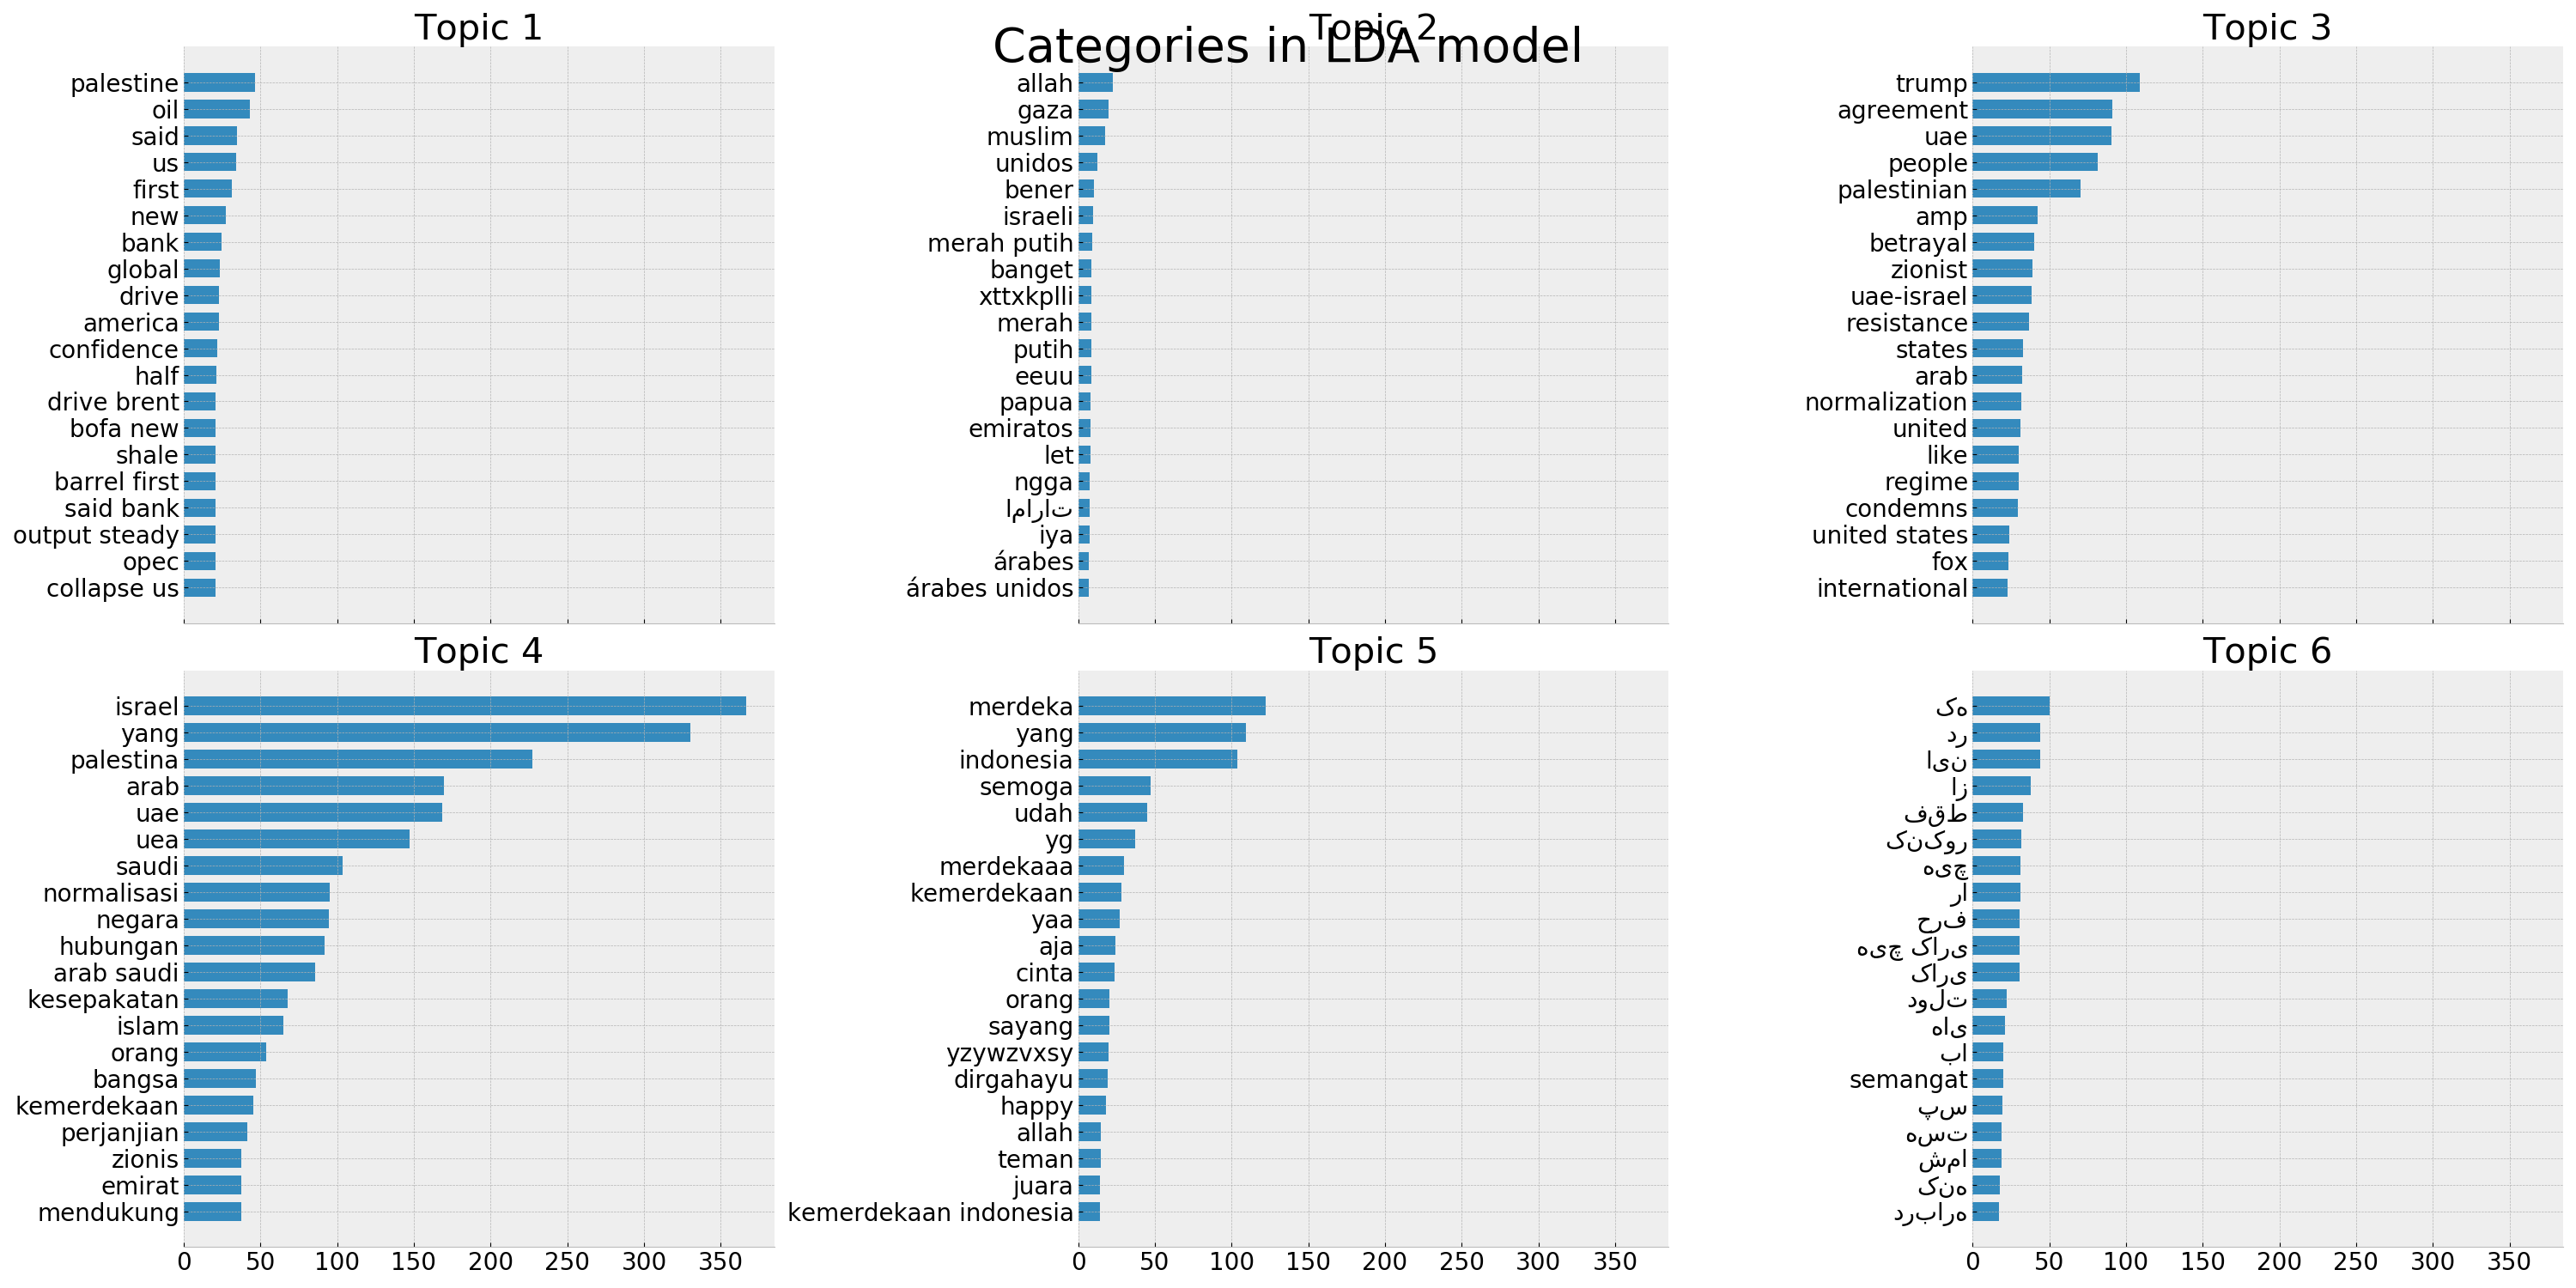

In [36]:
extract_topics(all_tweets,
               apply_preprocessing=False,
               n_features=2000,
               n_components=6)

### Topic modeling: categories of user
Tweets are first grouped by user; each user's aggregated tweet text is treated as a single document.

In [37]:
user_tweets = (top_day_tweets
              .groupby('userid')
              .agg({'tweet_text':string_agg}))
user_tweets.iloc[32]['tweet_text']

['Los colonos israelíes retiran las pancartas de las tiendas palestinas en la calle Shuhada, escritas en árabe al amparo de la oscuridad en el centro de Hebrón.\n#PalestinaLibre \n#FreePalastine \n#palestina https://t.co/X8yO7ukIbJ',
 'Los colonos israelíes prendieron fuego a una mezquita en la ciudad de Al Berih y rociaron consignas de odio y racistas en sus paredes.\n#PalestinaLibre \n#FreePalastine \n#palestina https://t.co/DCsMk5utft',
 'El Tribunal de Distrito de Israel en la Jerusalén Ocupada tiene órdenes de prohibir que el niño de 13 años, Zain Issam, ingrese a su aldea de Essawiya durante cinco días después de ponerlo en libertad con una fianza de 1465 dólares\n#palestinalivre \n#FreePalastine \n#palestina https://t.co/OqHSWqztyQ',
 'Los Musta’ribeen son soldados israelíes que visten como palestinos y están entrenados para conocer la zona palestina en la que operan.\n#PalestinaLibre\n#FreePalastine \n#palestina https://t.co/TakD9mcnx4',
 '@dcabellor El sionismo es racismo!  Es

In [38]:
user_tweets.iloc[33]['tweet_text']

['@realDonaldTrump You’re having a colorox overdose . Call your stupid doctor .']

In [39]:
len(user_tweets)

84

In [40]:
user_tweets.iloc[40]['tweet_text'][5:15]

['RT @79Tf6XH3DwjdUWGO4aQWghSj5G2esetBnePoOBB3wYM=: we are not like arabs we are much better than them. RIP UAE.\n#UAEBetraysPalestine',
 'RT @NhkHhabbhv123: let us pray for the safety of the Palestinian people especially those in Gaza, may Allah protect them ..Aamiin\n#Group4Pa…',
 'RT @Kareen_Sadaf: UEA ingin kami berdamai dengan orang-orang yang menulis ini di rumah orang Palestina\n\n#UAEBetraysPalestine https://t.co/Y…',
 'RT @79Tf6XH3DwjdUWGO4aQWghSj5G2esetBnePoOBB3wYM=: Palestine is not for sale!\n#UAEBetraysPalestine',
 'RT @79Tf6XH3DwjdUWGO4aQWghSj5G2esetBnePoOBB3wYM=: Shameful Trump administration obviously backs #UAEIsrael peace deal. He sells Palestinian lives for Jewish votes in presi…',
 'RT @79Tf6XH3DwjdUWGO4aQWghSj5G2esetBnePoOBB3wYM=: #Palestine is our not beacause of Arabs or Palestinians but because of #AlAqsa | End of  #UAEIsrael\n#UAEBetraysPalestine',
 'RT @79Tf6XH3DwjdUWGO4aQWghSj5G2esetBnePoOBB3wYM=: This agreement is a dagger behind all arab nations.\n#UAEBetra

In [41]:
per_user = (user_tweets['tweet_text']
             .apply(long_string)
             .apply(preprocess_string)
            )

vectorizing...
LDA:
n_samples: 2000
n_features: 2000
n_components: 6


<IPython.core.display.Javascript object>


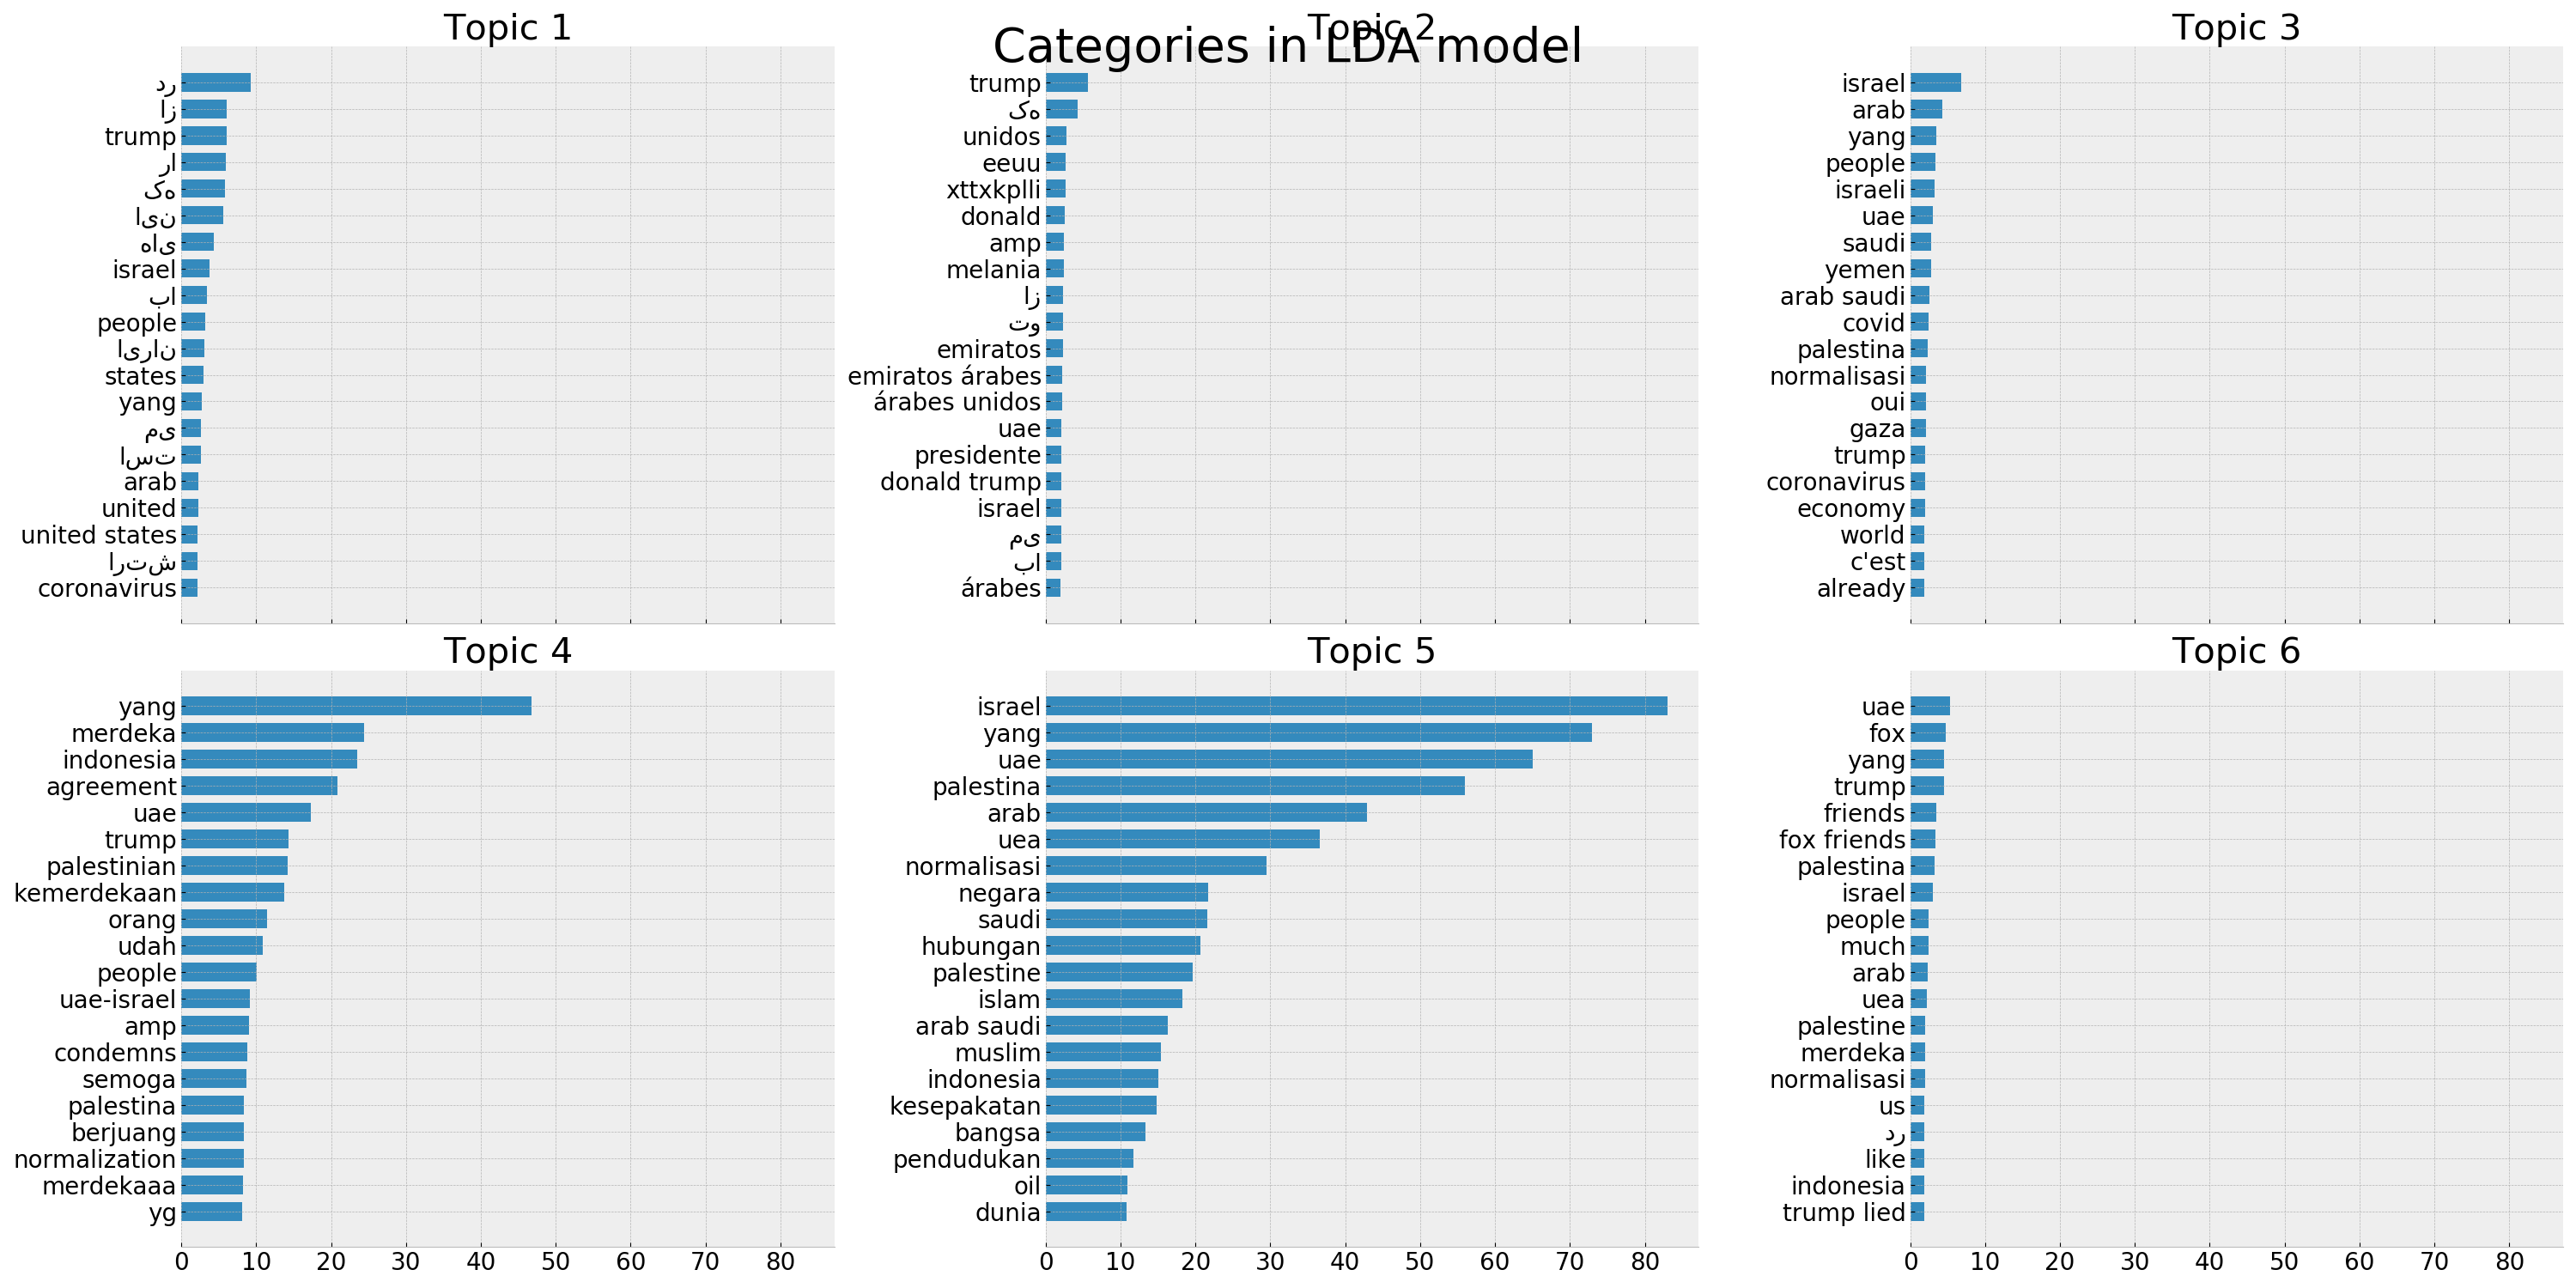

In [42]:
extract_topics(per_user,
               apply_preprocessing=False,
               n_features=2000,
               n_components=6)

## Account creation date

In [44]:
creation_ts = (campaign
               .groupby('account_creation_date')
               .size()
               .resample('d')
               .size()
              )
creation_ts

account_creation_date
2009-09-06    1
2009-09-07    0
2009-09-08    0
2009-09-09    0
2009-09-10    0
             ..
2020-10-06    1
2020-10-07    1
2020-10-08    1
2020-10-09    1
2020-10-10    1
Freq: D, Length: 4053, dtype: int64

<IPython.core.display.Javascript object>


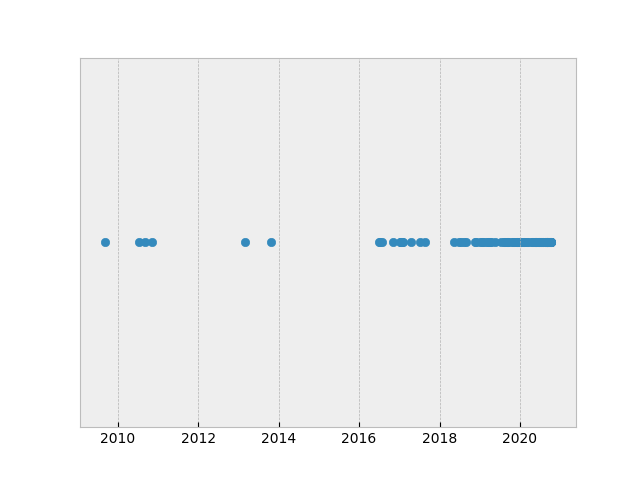

In [57]:
fig, ax = plt.subplots()

ax.scatter(creation_ts.index, creation_ts)
ax.set_ylim((0.8, 1.2))
ax.set_yticks([])

fig.show()